In [1]:
#

In [15]:
from dataclasses import dataclass
from typing import List
import numpy as np


class ScheduleInterval:
    def __init__(self, percent, schedule_type, multipliers, seq_len, total_steps):
        multipliers = [float(m) for m in multipliers.split("-")]
        percent = int(percent)
        self.validate_params(percent, schedule_type, multipliers)

        self.steps = round(int(percent) / 100 * total_steps)
        self.schedule_type = schedule_type
        self.interval_endpoints = [round(m * seq_len) - seq_len for m in multipliers]

    def validate_params(self, percent, schedule_type, multipliers):
        if not (0 < percent <= 100):
            raise ValueError(f"Percent must be between 1 and 100, got {percent}")

        if schedule_type == "const" and len(multipliers) != 1:
            raise ValueError(
                f"Const type should have exactly one multiplier, got {len(multipliers)}"
            )
        elif schedule_type in ["lin", "cos"] and len(multipliers) != 2:
            raise ValueError(
                f"{schedule_type.value} type should have exactly two multipliers, got {len(multipliers)}"
            )
        elif schedule_type not in ["const", "lin", "cos"]:
            raise ValueError(
                f"Unknown schedule type: {schedule_type}. Should be one of 'const', 'lin', 'cos'"
            )

        for m in multipliers:
            assert m >= 1 and m <= 5, "Multiplier should be between 1 and 5"


class TokenReductionScheduler:
    def __init__(self, total_steps, seq_len, schedule_str):
        self.total_steps = total_steps
        self.seq_len = seq_len
        self.schedule_steps = self._parse_schedule(schedule_str)
        self.current_step = 0

    def _parse_schedule(self, schedule_str):
        schedule_steps = []
        intervals = schedule_str.split(";")

        total_percent = 0

        for interval in intervals:
            split_interval = interval.split("_")

            if len(split_interval) != 3:
                raise ValueError(
                    f"Interval parameter should have form <percentage>_<type>_<multiplier/s>: {interval}"
                )

            percent, schedule_type, multipliers = split_interval
            schedule_step = ScheduleInterval(
                percent, schedule_type, multipliers, self.seq_len, self.total_steps
            )
            schedule_steps.append(schedule_step)
            total_percent += int(percent)

        if total_percent != 100:
            raise ValueError("Total percent of all intervals must equal 100")

        return schedule_steps

    def set_step(self, new_step):
        self.current_step = new_step

    def _linear_schedule(self, progress, interval_endpoints):
        return interval_endpoints[0] + progress * (
            interval_endpoints[1] - interval_endpoints[0]
        )

    def _cosine_schedule(self, progress, interval_endpoints):
        return interval_endpoints[0] + (1 - np.cos(progress * np.pi)) / 2 * (
            interval_endpoints[1] - interval_endpoints[0]
        )

    @property
    def value(self):
        sum_steps = 0
        for schedule_step in self.schedule_steps:
            if self.current_step < sum_steps + schedule_step.steps:
                progress = (self.current_step - sum_steps) / schedule_step.steps
                if schedule_step.schedule_type == "const":
                    return schedule_step.interval_endpoints[0]
                elif schedule_step.schedule_type == "lin":
                    return self._linear_schedule(
                        progress, schedule_step.interval_endpoints
                    )
                elif schedule_step.schedule_type == "cos":
                    return self._cosine_schedule(
                        progress, schedule_step.interval_endpoints
                    )
            sum_steps += schedule_step.steps

        return 0


# Example usage
total_steps = 100
seq_len = 32
# schedule_str = "45_const_1.1;45_lin_1.3-1.4;10_const_1.0"
schedule_str = "45_const_1.7;45_cos_1.7-1.3;10_const_1.2"
scheduler = TokenReductionScheduler(total_steps, seq_len, schedule_str)

In [27]:
heh = []
for i in range(total_steps):
    scheduler.set_step(i)
    heh.append(scheduler.value)

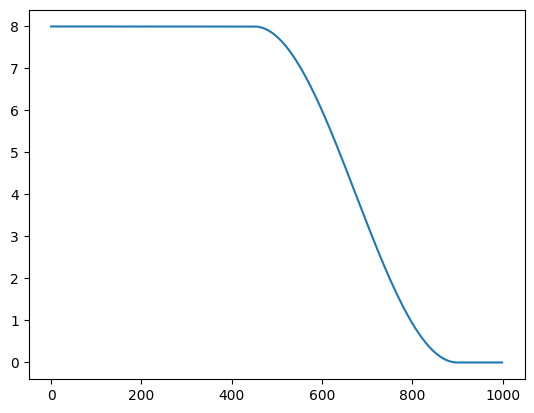

In [28]:
import matplotlib.pyplot as plt

plt.plot(heh)

In [30]:
# Example usage
total_steps = 1000
seq_len = 24
schedule_str = "45_const_1.33;45_cos_1.33-1;10_const_1"
scheduler = TokenReductionScheduler(total_steps, seq_len, schedule_str)

ValueError: Interval parameter should have form <percentage>_<type>_<multiplier/s>: 45_cos0.33-1

In [1]:
import torch

In [19]:
def make_droppable_available_tokens(
    token_inputs, result_seq_len, n_tokens_to_reduce, droppable_eot_id=False
):
    for tokens in token_inputs:
        (tokens[: result_seq_len + n_tokens_to_reduce] == GPT_EOT_ID).nonzero()

6

In [15]:
batch_size = 4
seq_len = 32
dm = 8
low, high = 0, 10
token_inputs = torch.randint(low, high, (batch_size, seq_len))

In [40]:
GPT_EOT_ID = 7


def make_available_tokens_without_eot_id(
    token_inputs, result_seq_len, n_tokens_to_reduce, eot_id
):
    droppable_ids, saved_ids = [], []
    for tokens in token_inputs:
        droppable_tokens_mask = tokens[: result_seq_len + n_tokens_to_reduce] != eot_id
        droppable_ids.append(droppable_tokens_mask.nonzero(as_tuple=True)[0])
        saved_ids.append((~droppable_tokens_mask).nonzero(as_tuple=True)[0])
    return droppable_ids, saved_ids



In [41]:
droppable_ids, saved_ids = make_droppable_available_tokens(
    token_inputs, result_seq_len=24, n_tokens_to_reduce=6, eot_id=GPT_EOT_ID
)

In [42]:
droppable_ids, saved_ids

([tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
  tensor([ 1,  2,  4,  5,  7,  8,  9, 10, 11, 13, 14, 15, 17, 18, 20, 21, 22, 23,
          24, 25, 26, 27, 28, 29]),
  tensor([ 0,  1,  2,  3,  4,  6,  7,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
          21, 22, 23, 24, 25, 26, 27, 28, 29]),
  tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18,
          19, 20, 21, 22, 24, 25, 26, 27, 28, 29])],
 [tensor([], dtype=torch.int64),
  tensor([ 0,  3,  6, 12, 16, 19]),
  tensor([ 5,  8, 13]),
  tensor([17, 23])])

In [43]:
available_ids = [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1, 2, 3, 4, 8, 9, 10]]
random_orders = [
    torch.randperm(len(ids)) for ids in available_ids
]
# pairs = [
#     (
#         available_ids[order])
#         available_ids[:n_tokens_to_reduce],
#     )
#     for order in random_orders
# ]


In [44]:
random_orders

[tensor([1, 9, 3, 8, 2, 4, 0, 5, 6, 7]), tensor([4, 6, 3, 5, 0, 2, 1])]

In [45]:
ehtte = torch.tensor([2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ehtte[random_orders[0]]

tensor([ 3, 11,  5, 10,  4,  6,  2,  7,  8,  9])